In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import glob
import os
import matplotlib.pyplot as plt

In [2]:
def backtest_with_benchmark(weights: pd.DataFrame,
                            returns_df: pd.DataFrame,
                            weights_benchmark: pd.DataFrame,
                            cost_rate: float = 0.001,
                            rf: float = 0.0):
    """
    Backtest a strategy against a benchmark, including transaction costs.
    
    Parameters
    ----------
    weights : pd.DataFrame
        Daily target weights for the strategy.
    returns_df : pd.DataFrame
        Daily returns DataFrame.
    weights_benchmark : pd.DataFrame
        Daily target weights for the benchmark.
    cost_rate : float
        Proportional transaction cost per unit turnover.
    rf : float
        Annual risk-free rate for Sharpe ratio calculation.
        
    Returns
    -------
    results : dict
        Contains:
            - net_returns_strategy, cumulative_strategy, metrics_strategy
            - net_returns_benchmark, cumulative_benchmark, metrics_benchmark
    """
    # Strategy raw returns
    strat_raw = (weights * returns_df).sum(axis=1)
    # Strategy turnover & costs
    strat_turn = weights.diff().abs().sum(axis=1)
    strat_turn.iloc[0] = weights.iloc[0].abs().sum()
    strat_costs = strat_turn * cost_rate
    strat_net = strat_raw - strat_costs
    strat_cum = (1 + strat_net).cumprod()
    print("strat_cum")
    print(strat_cum)
    
    # Benchmark raw returns
    bench_raw = (weights_benchmark * returns_df).sum(axis=1)
    # Benchmark turnover & costs
    bench_turn = weights_benchmark.diff().abs().sum(axis=1)
    bench_turn.iloc[0] = weights_benchmark.iloc[0].abs().sum()
    bench_costs = bench_turn * cost_rate
    bench_net = bench_raw - bench_costs
    bench_cum = (1 + bench_net).cumprod()
    print("bench_cum")
    print(bench_cum)
    
    def compute_metrics(net_ret, cum_ret):
        n = net_ret.shape[0]
        total = cum_ret.iloc[-1]
        ann_ret = total ** (252 / n) - 1
        ann_vol = net_ret.std() * np.sqrt(252)
        sharpe = (ann_ret - rf) / ann_vol if ann_vol != 0 else np.nan
        dd = cum_ret / cum_ret.cummax() - 1
        max_dd = dd.min()
        return {
            'annual_return': ann_ret,
            'annual_volatility': ann_vol,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd
        }
    
    metrics_strat = compute_metrics(strat_net, strat_cum)
    metrics_bench = compute_metrics(bench_net, bench_cum)
    
    plt.figure(figsize=(10, 5))
    strat_cum.plot(label='Strategy')
    bench_cum.plot(label='Benchmark')   
    plt.title('Cumulative Returns: Strategy vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return {
        'net_returns_strategy': strat_net,
        'cumulative_strategy': strat_cum,
        'metrics_strategy': metrics_strat,
        'net_returns_benchmark': bench_net,
        'cumulative_benchmark': bench_cum,
        'metrics_benchmark': metrics_bench
    }




In [3]:
# Returns
csv_files = glob.glob("../raw_data/*.csv")
dfs = {}
for file in csv_files:
    symbol = os.path.splitext(os.path.basename(file))[0]
    if symbol in ['BF.B','BRK.B','CTLT']:
        continue
    df = pd.read_csv(file, index_col=0 )

    df = df[~df.index.duplicated(keep='first')]
    num_cols = ["open", "high", "low", "close", "vol", "pct_change", "vwap"]
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    df['return'] = df['pct_change'] / 100.0
    dfs[symbol] = df

In [4]:
# expected returns
csv_files = glob.glob("../output/predictions/expected_returns/*.csv")
dfs_return = []
for file in csv_files:
    df = pd.read_csv(file, index_col=0)
    df = df[~df.index.duplicated(keep='first')]
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    dfs_return.append(df)

In [5]:
# volatilities
csv_files = glob.glob("../output/predictions/volatilities/*.csv")
dfs_volatility = []
for file in csv_files:
    df = pd.read_csv(file, index_col=0)
    df = df[~df.index.duplicated(keep='first')]
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    dfs_volatility.append(df)

In [6]:
returns_df = pd.DataFrame({sym: df['return'] for sym, df in dfs.items()}).sort_index()
expected_returns = pd.concat(dfs_return, axis=0).sort_index()
expected_volatility = pd.concat(dfs_volatility, axis=0).sort_index()


In [7]:
score_df = expected_returns / expected_volatility
score_df = score_df.rolling(window=40).mean()

In [8]:
position = pd.DataFrame(index=score_df.index, columns=returns_df.columns).sort_index()
benchmark_position = position.copy().sort_index()
benchmark_position.loc[:, :] = 1 / len(benchmark_position.columns)
for i in trange(len(score_df)):
    score = score_df.iloc[i]
    score = score[score > 0].sort_values(ascending=True)
    weight = np.arange(1, len(score)+1) / np.sum(np.arange(1, len(score)+1))
    position.iloc[i, :] = 0.0
    if len(weight) > 0:
        position.loc[score_df.index[i], score.index] = weight

  0%|          | 0/1929 [00:00<?, ?it/s]

In [9]:
returns_df = returns_df.loc[position.index, position.columns]

## Without transaction cost

strat_cum
2021-04-01         1.0
2021-04-05         1.0
2021-04-06         1.0
2021-04-07         1.0
2021-04-08         1.0
                ...   
2018-10-25    9.610225
2018-10-26    9.610225
2018-10-29    9.610225
2018-10-30    9.610225
2018-10-31    9.610225
Length: 1929, dtype: object
bench_cum
2021-04-01    1.011314
2021-04-05    1.020888
2021-04-06    1.022095
2021-04-07    1.018502
2021-04-08    1.020413
                ...   
2018-10-25     2.62034
2018-10-26    2.583059
2018-10-29    2.576198
2018-10-30    2.625337
2018-10-31    2.649284
Length: 1929, dtype: object


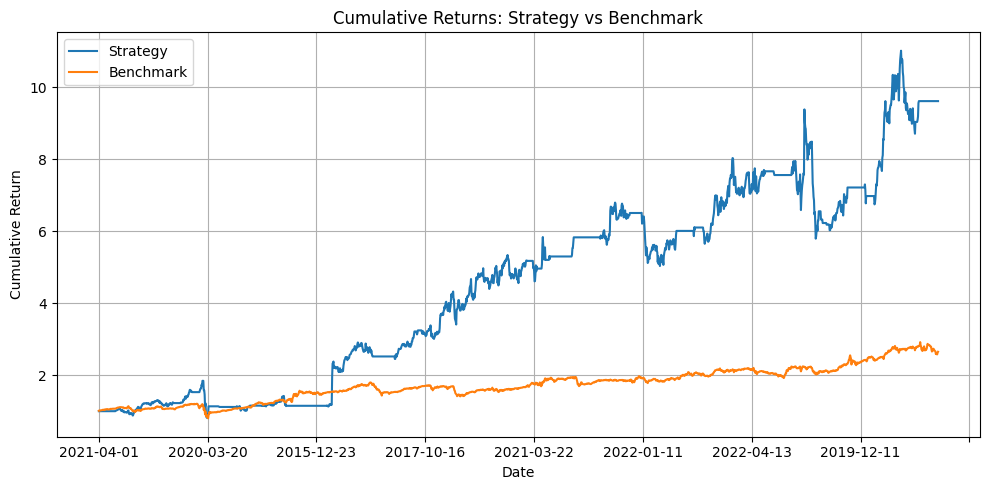

{'net_returns_strategy': 2021-04-01    0.0
2021-04-05    0.0
2021-04-06    0.0
2021-04-07    0.0
2021-04-08    0.0
             ... 
2018-10-25    0.0
2018-10-26    0.0
2018-10-29    0.0
2018-10-30    0.0
2018-10-31    0.0
Length: 1929, dtype: object, 'cumulative_strategy': 2021-04-01         1.0
2021-04-05         1.0
2021-04-06         1.0
2021-04-07         1.0
2021-04-08         1.0
                ...   
2018-10-25    9.610225
2018-10-26    9.610225
2018-10-29    9.610225
2018-10-30    9.610225
2018-10-31    9.610225
Length: 1929, dtype: object, 'metrics_strategy': {'annual_return': 0.34394652933780034, 'annual_volatility': np.float64(0.4319310387338801), 'sharpe_ratio': np.float64(0.7962996369652229), 'max_drawdown': -0.557332781609722}, 'net_returns_benchmark': 2021-04-01    0.011314
2021-04-05    0.009467
2021-04-06    0.001182
2021-04-07   -0.003515
2021-04-08    0.001876
                ...   
2018-10-25    0.012943
2018-10-26   -0.014227
2018-10-29   -0.002656
2018-10-30    

In [10]:
results = backtest_with_benchmark(position, returns_df, benchmark_position, cost_rate=0.000)
print(results)

In [11]:
print("Strategy Metrics:", results['metrics_strategy'])
print("Benchmark Metrics:", results['metrics_benchmark'])

Strategy Metrics: {'annual_return': 0.34394652933780034, 'annual_volatility': np.float64(0.4319310387338801), 'sharpe_ratio': np.float64(0.7962996369652229), 'max_drawdown': -0.557332781609722}
Benchmark Metrics: {'annual_return': 0.1357336696183078, 'annual_volatility': np.float64(0.19139668012388308), 'sharpe_ratio': np.float64(0.7091746289980215), 'max_drawdown': -0.3367966657712542}


## With transaction cost

strat_cum
2021-04-01         1.0
2021-04-05         1.0
2021-04-06         1.0
2021-04-07         1.0
2021-04-08         1.0
                ...   
2018-10-25    6.942068
2018-10-26    6.942068
2018-10-29    6.942068
2018-10-30    6.942068
2018-10-31    6.942068
Length: 1929, dtype: object
bench_cum
2021-04-01    1.009314
2021-04-05    1.018869
2021-04-06    1.020073
2021-04-07    1.016488
2021-04-08    1.018395
                ...   
2018-10-25    2.615157
2018-10-26    2.577951
2018-10-29    2.571103
2018-10-30    2.620145
2018-10-31    2.644044
Length: 1929, dtype: object


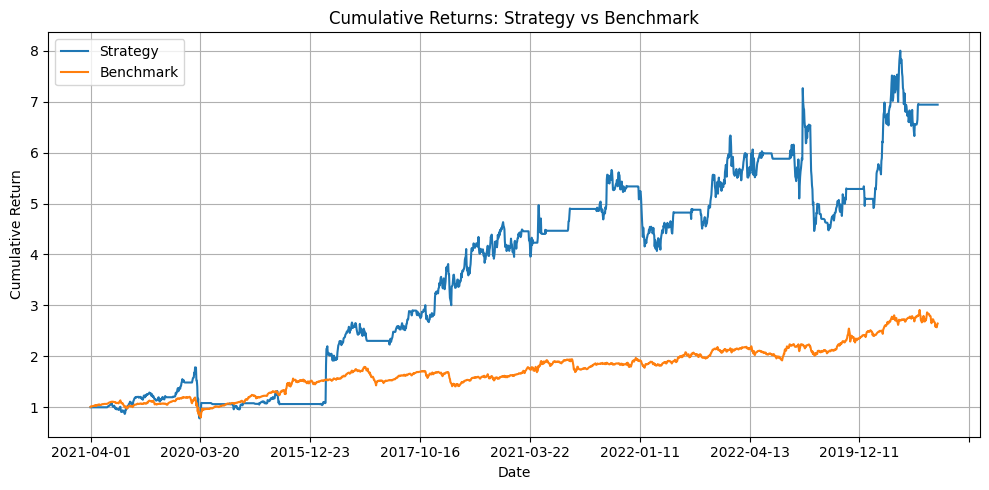

{'net_returns_strategy': 2021-04-01    0.0
2021-04-05    0.0
2021-04-06    0.0
2021-04-07    0.0
2021-04-08    0.0
             ... 
2018-10-25    0.0
2018-10-26    0.0
2018-10-29    0.0
2018-10-30    0.0
2018-10-31    0.0
Length: 1929, dtype: object, 'cumulative_strategy': 2021-04-01         1.0
2021-04-05         1.0
2021-04-06         1.0
2021-04-07         1.0
2021-04-08         1.0
                ...   
2018-10-25    6.942068
2018-10-26    6.942068
2018-10-29    6.942068
2018-10-30    6.942068
2018-10-31    6.942068
Length: 1929, dtype: object, 'metrics_strategy': {'annual_return': 0.28804227239576474, 'annual_volatility': np.float64(0.43175909636739246), 'sharpe_ratio': np.float64(0.6671365463268984), 'max_drawdown': -0.5610796006562633}, 'net_returns_benchmark': 2021-04-01    0.009314
2021-04-05    0.009467
2021-04-06    0.001182
2021-04-07   -0.003515
2021-04-08    0.001876
                ...   
2018-10-25    0.012943
2018-10-26   -0.014227
2018-10-29   -0.002656
2018-10-30  

In [12]:
results = backtest_with_benchmark(position, returns_df, benchmark_position, cost_rate=0.002)
print(results)

In [13]:
print("Strategy Metrics:", results['metrics_strategy'])
print("Benchmark Metrics:", results['metrics_benchmark'])

Strategy Metrics: {'annual_return': 0.28804227239576474, 'annual_volatility': np.float64(0.43175909636739246), 'sharpe_ratio': np.float64(0.6671365463268984), 'max_drawdown': -0.5610796006562633}
Benchmark Metrics: {'annual_return': 0.13543999768652015, 'annual_volatility': np.float64(0.1913833819664141), 'sharpe_ratio': np.float64(0.7076894362243454), 'max_drawdown': -0.33679666577125456}
